In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random

from copy import deepcopy

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

import Preprocessor
import Parameters
import HHMM
import Visualisor

rand_seed = 0

random.seed(rand_seed)
np.random.seed(rand_seed)

# Initialize parameters

In [13]:
### initialize parameters ####
ndives = 100
ndatasets = 1

# number of states for each substate
K0 = 2
K1 = 3

# dive duration parameters
dd_mu = np.array([27.27,127.07])
dd_sig = np.array([10.91,64.06])

dd_shape = np.square(dd_mu)/np.square(dd_sig)
dd_scale = np.square(dd_sig)/np.array(dd_mu)

# FoVeDBA parameters (this is for the SQUARE of the FoVeDBA)

# make shape decay like 1/n
FoVeDBA_sin_shape = np.array([[(1.0/n**3) for n in range(1,52)] for _ in range(K1)])
for i in range(K1):
    FoVeDBA_sin_shape[i,:] = FoVeDBA_sin_shape[i,:]/sum(FoVeDBA_sin_shape[i,1:11])

# scale needs to be constant
FoVeDBA_sin_scale = np.ones((K1,51))

# set mean and variance
FoVeDBA_mu = np.array([[34.98],[505.79],[9769.98]])
FoVeDBA_sig = np.array([[23.85],[516.68],[14462.55]])

# adjust shape and scale accordingly
FoVeDBA_sin_shape *= np.square(FoVeDBA_mu)/np.square(FoVeDBA_sig)
FoVeDBA_sin_scale *= np.square(FoVeDBA_sig)/FoVeDBA_mu

# average acceleration parameters
acc_mu = np.array([0.0,0.1,0.2])
acc_sig = np.array([0.05,0.1,0.3])

# intialize correlation within states
corr_crude = [0.0,0.0,0.0]
corr_fine = [0.97,0.83,0.61]

# randomly initialize a probablity transition matrix

ptm_crude = np.array([[0.85,0.15],
                      [0.91,0.09]])

eta_crude = np.array([[ 0.    , -1.6984],
                      [ 2.3471,  0.    ]])

ptm_fine = [np.array([[0.75,0.25,0.00],
                      [0.08,0.87,0.05],
                      [0.00,0.23,0.77]]),
            np.array([[0.89,0.11,0.00],
                      [0.15,0.81,0.04],
                      [0.00,0.23,0.77]])]

eta_fine =  [np.array([[  0.    ,  -1.0873, -10.00 ],
                       [ -2.3615,   0.    , -2.823 ],
                       [ -10.000,  -1.1937,  0.    ]]),
              np.array([[  0.    ,  -2.0691,  -10.000],
                        [ -1.6902,   0.    ,  -3.1311],
                        [ -10.000,  -1.2303,   0.    ]])]

# train new models?
train_new = True

In [14]:
print(sum(FoVeDBA_sin_shape[0,1:11]))
print(np.sqrt(sum(FoVeDBA_sin_shape[0,1:11]))*FoVeDBA_sin_scale[0,0])

print(sum(FoVeDBA_sin_shape[1,1:11]))
print(np.sqrt(sum(FoVeDBA_sin_shape[1,1:11]))*FoVeDBA_sin_scale[1,0])

2.15111111111111
23.85
0.9582904838071772
516.68


In [15]:
# initialize the initial states
delta_crude = np.ones(K0)/K0
for _ in range(100):
    delta_crude = delta_crude.dot(ptm_crude)
    
delta_fines = []
for k0 in range(K0):
    delta_fine = np.ones(K1)/K1
    for _ in range(100):
        delta_fine = delta_fine.dot(ptm_fine[k0])
    delta_fines.append(delta_fine)

# Create Data 

In [16]:
def create_data():

    data = []
    data_V = []
    data_FV = []
    freqs = np.fft.rfftfreq(100, d=1/50.0)
    thresh = 5
    thresh_ind = max(np.where(freqs <= thresh)[0]) + 1

    time = 0

    for dive_num in range(ndives):

        # select dive type
        if dive_num == 0:
            dive_type = np.random.choice(K0,p=delta_crude)
            dd_mu_t = np.copy(dd_mu[dive_type])
        else:
            dive_type_tm1 = dive_type
            dive_type = np.random.choice(K0,p=ptm_crude[dive_type,:])
            dd_mu_t = np.copy(dd_mu[dive_type])
            dd_mu_t = corr_crude[dive_type]*dd_tm1 + (1.0-corr_crude[dive_type])*dd_mu_t

        # select dive duration
        dd_sig_t = dd_sig[dive_type]
        dd_shape_t = np.square(dd_mu_t)/np.square(dd_sig_t)
        dd_scale_t = np.square(dd_sig_t)/np.array(dd_mu_t)

        dive_duration = gamma.rvs(dd_shape_t,0,dd_scale_t)
        dd_tm1 = dive_duration
        datum = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_V = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_FV = {'dive_type': dive_type, 'dive_duration': dive_duration}
        nsegs = int(dive_duration/2.0)

        subdive_features = []
        subdive_features_V = []
        subdive_features_FV = []

        for seg_num in range(nsegs):

            seg = {}
            seg_V = [{},{}]
            seg_FV = {}

            # find seg type
            if seg_num == 0:
                subdive_type = np.random.choice(K1,p=delta_fines[dive_type])
                FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
                acc_mu_t = np.copy(acc_mu[subdive_type])
            else:
                subdive_type = np.random.choice(K1,p=ptm_fine[dive_type][subdive_type,:])
                FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
                acc_mu_t = np.copy(acc_mu[subdive_type])
                acc_mu_t = corr_fine[subdive_type]*acc_tm1 + (1.0-corr_fine[subdive_type])*acc_mu_t

            seg['subdive_type'] = subdive_type
            seg_FV['subdive_type'] = subdive_type
            seg_V[0]['subdive_type'] = subdive_type
            seg_V[1]['subdive_type'] = subdive_type

            # find average acceleration
            acc_sig_t = acc_sig[subdive_type]

            # find FoVeDBA
            FoVeDBA_sin_sig2_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]**2
            FoVeDBA_sin_shape_t = np.square(FoVeDBA_sin_mu_t)/FoVeDBA_sin_sig2_t
            FoVeDBA_sin_scale_t = FoVeDBA_sin_sig2_t/FoVeDBA_sin_mu_t
            FoVeDBA_sin = gamma.rvs(FoVeDBA_sin_shape_t,0,FoVeDBA_sin_scale_t)
            FoVeDBA_sin_tm1 = np.copy(FoVeDBA_sin)

            seg['FoVeDBA_full'] = FoVeDBA_sin.T
            seg['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001
            seg_FV['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001

            # find VeDBA
            pm = (2*np.random.choice(2,size = FoVeDBA_sin.shape)-1)
            FoVeDBA = pm*np.sqrt(FoVeDBA_sin)*1.0j
            A = np.array(np.fft.irfft(FoVeDBA))
            V0 = norm.rvs(acc_mu_t,acc_sig_t)
            acc_tm1 = V0
            A += np.linspace(V0,V0,100).T

            seg['A'] = A
            seg['avg_A'] = np.mean(A)
            seg_V[0]['A'] = np.mean(A[:50])
            seg_V[1]['A'] = np.mean(A[50:])
            seg_FV['A'] = np.mean(A)

            # find time
            seg['time'] = np.arange(time,time+2,1/50)
            time += 2

            subdive_features.append(seg)
            subdive_features_V.append(seg_V[0])
            subdive_features_V.append(seg_V[1])
            subdive_features_FV.append(seg_FV)

        datum['subdive_features'] = subdive_features
        datum_V['subdive_features'] = subdive_features_V
        datum_FV['subdive_features'] = subdive_features_FV

        data.append(datum)
        data_V.append(datum_V)
        data_FV.append(datum_FV)

    return data,data_V,data_FV

data,data_V,data_FV = create_data()

0.08463198435965603
0.20335126132802234
[46.50268809]


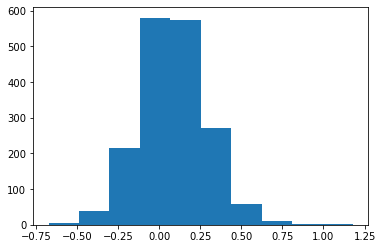

In [17]:
As = []
for dive in data_FV:
    As.extend([seg['A'] for seg in dive['subdive_features']])
plt.hist(As)
print(np.mean(As))
print(np.std(As))
print(np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))]))

# Visualize Data 

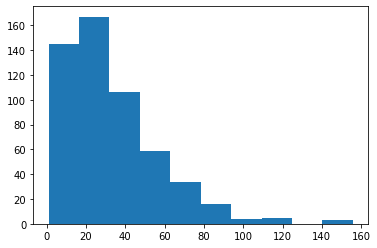

33.39097283145866
24.21582454635671


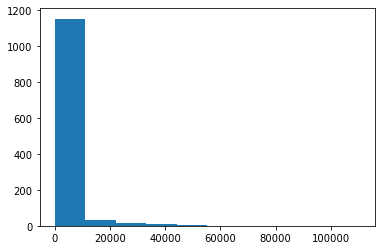

1947.3914936090619
6390.817263530309

[  34.98  505.79 9769.98]
[   23.85   516.68 14462.55]


In [18]:
FO0 = []
FO1 = []
for dive in data_FV:
    for seg in dive['subdive_features']:
        if seg['subdive_type'] == 0:
            FO0.append(seg['FoVeDBA'])
        else:
            FO1.append(seg['FoVeDBA'])
        
plt.hist(FO0)
plt.show()
print(np.mean(FO0))
print(np.std(FO0))
plt.hist(FO1)
plt.show()
print(np.mean(FO1))
print(np.std(FO1))

print('')

print(FoVeDBA_sin_scale[:,0]*np.sum(FoVeDBA_sin_shape[:,1:11],1))
print(np.sqrt(((FoVeDBA_sin_scale[:,0]**2)*np.sum(FoVeDBA_sin_shape[:,1:11],1))))

# Find intial thetas for training

In [19]:
### CarHMM ###
hmm_FV_theta = [{'dive_duration': {'mu': np.array([np.mean(dd_mu)]),
                                   'sig': np.array([np.sqrt(np.mean(dd_sig**2) + np.var(dd_mu))]),
                                   'corr': np.array([-10.])}},
                 [{'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                               'sig': FoVeDBA_sig.flatten(),
                               'corr': np.array([ -10. for _ in range(K1)])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

eta_fine_temp = eta_fine[0]/2 + eta_fine[1]/2

hmm_FV_eta = [np.array([[0]]),
             [eta_fine_temp]]


### CarHHMM, no Z2 ###
hhmm_V_theta = [{'dive_duration': {'mu': dd_mu,
                                   'sig': dd_sig,
                                   'corr': np.array([ -10. for _ in range(K0)])}},
                 [{'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}},
                  {'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

hhmm_V_eta = [eta_crude,eta_fine]


### HHMM ###
hhmm_FV_uncorr_theta = [{'dive_duration': {'mu': dd_mu,
                                           'sig': dd_sig,
                                           'corr': np.array([ -10. for _ in range(K0)])}},
                         [{'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                                       'sig': FoVeDBA_sig.flatten(),
                                       'corr': np.array([ -10. for _ in range(K1)])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([ -10. for _ in range(K1)])}},
                          {'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                                       'sig': FoVeDBA_sig.flatten(),
                                       'corr': np.array([ -10. for _ in range(K1)])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([ -10. for _ in range(K1)])}}]]

hhmm_FV_uncorr_eta = [eta_crude,eta_fine]

### CarHHMM ###
hhmm_FV_theta = [{'dive_duration': {'mu': dd_mu,
                                    'sig': dd_sig,
                                    'corr': np.array([ -10. for _ in range(K0)])}},
                 [{'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                               'sig': FoVeDBA_sig.flatten(),
                               'corr': np.array([ -10. for _ in range(K1)])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}},
                 {'FoVeDBA': {'mu': FoVeDBA_mu.flatten(),
                               'sig': FoVeDBA_sig.flatten(),
                               'corr': np.array([ -10. for _ in range(K1)])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

hhmm_FV_eta = [eta_crude,eta_fine]

# Try to relearn generative parameters many times

In [20]:
pars = Parameters.Parameters()
pars.K = [2,2]
pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA':{'corr':False,'f':'gamma'},
                  'A':{'corr':True,'f':'normal'}}]

hhmm_FV = HHMM.HHMM(pars,data_FV)
hhmm_FV.theta = deepcopy(hhmm_FV_theta)
hhmm_FV.eta = deepcopy(hhmm_FV_eta)
hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)

In [21]:
hhmm_FV.theta

[{'dive_duration': {'mu': array([ 27.27, 127.07]),
   'sig': array([10.91, 64.06]),
   'corr': array([-10., -10.])}},
 [{'FoVeDBA': {'mu': array([  34.98,  505.79, 9769.98]),
    'sig': array([   23.85,   516.68, 14462.55]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0. , 0.1, 0.2]),
    'sig': array([0.05, 0.1 , 0.3 ]),
    'corr': array([3.47609869, 1.58562726, 0.44731222])}},
  {'FoVeDBA': {'mu': array([  34.98,  505.79, 9769.98]),
    'sig': array([   23.85,   516.68, 14462.55]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0. , 0.1, 0.2]),
    'sig': array([0.05, 0.1 , 0.3 ]),
    'corr': array([3.47609869, 1.58562726, 0.44731222])}}]]

In [ ]:
datasets = []
datasets_V = []
datasets_FV = []

hmm_FVs = []
hhmm_Vs = []
hhmm_FV_uncorrs = []
hhmm_FVs = []

h = 0.001

model = 'all'

for dataset_num in [-1]:


    ### generate data ###
    print('')
    print('GENERATING DATA')
    print('')
    data,data_V,data_FV = create_data()

    for dive in data_FV:
        print(dive['dive_type'])
        print(dive['dive_duration'])
        for seg in dive['subdive_features']:
            print(seg)


    ### CarHMM ###
    if model in ['CarHMM','all']:
        print('')
        print('STARTING CarHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [1,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':True,'f':'normal'}}]
        pars.theta = hmm_FV_theta

        hmm_FV = HHMM.HHMM(pars,data_FV)
        hmm_FV.theta = hmm_FV_theta
        hmm_FV.eta = hmm_FV_eta
        hmm_FV.true_theta = deepcopy(hmm_FV_theta)
        hmm_FV.true_eta = deepcopy(hmm_FV_eta)

        hmm_FV.train_DM(data_FV,max_iters=10,max_steps=10)
        hmm_FV.get_SEs(data_FV,h)
        data,data_V,data_FV = create_data()

        # make test data
        for dive_num,datum in enumerate(data_FV):
            _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
            for i,post in enumerate(posts.T):
                data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
                data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post

        # get confusion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hmm_FV_dive']
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hmm_FV_dive'])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hmm_FV_subdive'][k]

        hmm_FV.CM = [CM_coarse,CM_fine]

        # save data
        hmm_FV.save('../../Params/sims/local/hmm_FV_%d_%d'%(dataset_num,rand_seed))


    ### HHMM ###
    if model in ['HHMM','all']:
        print('')
        print('STARTING HHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [K0,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':False,'f':'normal'}}]

        hhmm_FV_uncorr = HHMM.HHMM(pars,data_FV)
        hhmm_FV_uncorr.theta = hhmm_FV_uncorr_theta
        hhmm_FV_uncorr.eta = hhmm_FV_uncorr_eta
        hhmm_FV_uncorr.true_theta = deepcopy(hhmm_FV_uncorr_theta)
        hhmm_FV_uncorr.true_eta = deepcopy(hhmm_FV_uncorr_eta)

        hhmm_FV_uncorr.train_DM(data_FV,max_iters=10,max_steps=10)
        hhmm_FV_uncorr.get_SEs(data_FV,h)
        data,data_V,data_FV = create_data()

        # crude posterior
        _,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_FV):
            data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
            _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = np.array([posts_crude.T[dive_num,0]*post_fine_0[k] + \
                              posts_crude.T[dive_num,1]*post_fine_1[k] for k in range(K1)])
                data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
                data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]

        # get confusion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_uncorr_dive']
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_uncorr_dive'])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hhmm_FV_uncorr_subdive'][k]

        hhmm_FV_uncorr.CM = [CM_coarse,CM_fine]

        hhmm_FV_uncorr.save('../../Params/sims/local/hhmm_FV_uncorr_%d_%d'%(dataset_num,rand_seed))


    ### CarHHMM, no Z2 ###
    if model in ['CarHHMM1','all']:
        print('')
        print('STARTING CarHHMM minux Z2')
        print('')
        pars = Parameters.Parameters()
        pars.K = [K0,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'A':{'corr':True,'f':'normal'}}]

        hhmm_V = HHMM.HHMM(pars,data_V)
        hhmm_V.theta = hhmm_V_theta
        hhmm_V.eta = hhmm_V_eta
        hhmm_V.true_theta = deepcopy(hhmm_V_theta)
        hhmm_V.true_eta = deepcopy(hhmm_V_eta)

        hhmm_V.train_DM(data_V,max_iters=10,max_steps=10)
        hhmm_V.get_SEs(data_V,h)
        data,data_V,data_FV = create_data()

        # crude posterior
        _,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_V):
            data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
            _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = np.array([posts_crude.T[dive_num,0]*post_fine_0[k] + \
                              posts_crude.T[dive_num,1]*post_fine_1[k] for k in range(K1)])
                if i%2 == 0:
                    p0 = p
                else:
                    data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
                    data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,1]

        # get confustion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_V_dive']
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_V_dive'])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hhmm_V_subdive'][k]

        hhmm_V.CM = [CM_coarse,CM_fine]
        hhmm_V.save('../../Params/sims/local/hhmm_V_%d_%d'%(dataset_num,rand_seed))


    ### CarHHMM ###
    if model in ['CarHHMM2','all']:
        print('')
        print('STARTING CarHHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [K0,K1]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':True,'f':'normal'}}]

        hhmm_FV = HHMM.HHMM(pars,data_FV)
        hhmm_FV.theta = hhmm_FV_theta
        hhmm_FV.eta = hhmm_FV_eta
        hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
        hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)

        hhmm_FV.train_DM(data_FV,max_iters=10,max_steps=10)
        hhmm_FV.get_SEs(data_FV,h)
        data,data_V,data_FV = create_data()

        # crude posterior
        _,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_FV):
            _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = [posts_crude.T[dive_num,0]*post_fine_0[k] + \
                     posts_crude.T[dive_num,1]*post_fine_1[k] for k in range(K1)]
                data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
                data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]

        # get confusion matrix
        CM_coarse = np.zeros((K0,K0))
        CM_fine = [np.zeros((K1,K1)) for _ in range(K0)]
        for dive in data:
            dive_type = dive['dive_type']
            CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_dive']
            CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_dive'])
            for seg in dive['subdive_features']:
                subdive_type = seg['subdive_type']
                for k in range(K1):
                    CM_fine[dive_type][subdive_type,k] += seg['hhmm_FV_subdive'][k]

        hhmm_FV.CM = [CM_coarse,CM_fine]

        # save hmms
        hhmm_FV.save('../../Params/sims/local/hhmm_FV_%d_%d'%(dataset_num,rand_seed))


GENERATING DATA

0
26.71341355983088
{'subdive_type': 0, 'FoVeDBA': 17.838278488996853, 'A': -0.028107448185913438}
{'subdive_type': 0, 'FoVeDBA': 18.038816094531384, 'A': -0.041242138408055434}
{'subdive_type': 0, 'FoVeDBA': 49.081135425363954, 'A': -0.06627855458481707}
{'subdive_type': 0, 'FoVeDBA': 46.73437727576056, 'A': -0.08503581771952401}
{'subdive_type': 0, 'FoVeDBA': 52.4442811401299, 'A': -0.08717973431086035}
{'subdive_type': 0, 'FoVeDBA': 48.344081882830686, 'A': -0.12213005418804412}
{'subdive_type': 0, 'FoVeDBA': 55.44293990834959, 'A': -0.23823437276111398}
{'subdive_type': 1, 'FoVeDBA': 728.8474208068966, 'A': -0.13643457669260967}
{'subdive_type': 1, 'FoVeDBA': 505.22416351120364, 'A': -0.008691139216189683}
{'subdive_type': 1, 'FoVeDBA': 943.6395768486793, 'A': -0.052219093435616155}
{'subdive_type': 1, 'FoVeDBA': 1095.240813171316, 'A': -0.07404950994716296}
{'subdive_type': 1, 'FoVeDBA': 84.54373696033073, 'A': 0.016672549694505445}
{'subdive_type': 1, 'FoVeDBA':

{'subdive_type': 1, 'FoVeDBA': 14.444819791105935, 'A': -0.019596914680072255}
{'subdive_type': 0, 'FoVeDBA': 5.885049682786622, 'A': -0.12377589512929163}
{'subdive_type': 0, 'FoVeDBA': 7.95370832727566, 'A': -0.08495833718258729}
{'subdive_type': 0, 'FoVeDBA': 16.36490826114139, 'A': -0.13755466984793055}
{'subdive_type': 0, 'FoVeDBA': 59.13741515379941, 'A': -0.23689394672558656}
{'subdive_type': 1, 'FoVeDBA': 88.26183057441763, 'A': -0.0020621968155522304}
{'subdive_type': 2, 'FoVeDBA': 550.0194103510325, 'A': 0.202485233721823}
{'subdive_type': 2, 'FoVeDBA': 1214.0167327647564, 'A': 0.5093803143672386}
{'subdive_type': 2, 'FoVeDBA': 8485.221777455614, 'A': 0.41851690837136696}
{'subdive_type': 2, 'FoVeDBA': 3979.7460782282524, 'A': -0.14892985048732138}
{'subdive_type': 1, 'FoVeDBA': 72.65024456725006, 'A': -0.08787222317378499}
{'subdive_type': 1, 'FoVeDBA': 721.1988034819341, 'A': 0.032664126445069636}
{'subdive_type': 0, 'FoVeDBA': 7.741806055530044, 'A': -0.05316666469788815}


ITERATION 0
-12061.959673468291

N = 1, no Coarse Gamma
updated coarse theta dive_duration, state 0, param mu
original:  77.17
 final_simplex: (array([[67.01129297],
       [67.0414375 ]]), array([12057.4856402 , 12057.48566607]))
           fun: 12057.485640204433
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([67.01129297])
time taken:  11.07670783996582  seconds

updated coarse theta dive_duration, state 0, param sig
original:  67.83336826370927
 final_simplex: (array([[56.22750291],
       [56.28049773]]), array([12053.61374954, 12053.61383851]))
           fun: 12053.613749543163
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([56.22750291])
time taken:  11.014230012893677  seconds

updated fine eta, dive 0, row 0
original:  [  0.      -1.5782 -10.

updated fine theta A, dive_state 0 subdive state 2, param sig
original:  0.3
 final_simplex: (array([[0.29578125],
       [0.29572266]]), array([12042.18276897, 12042.18277106]))
           fun: 12042.18276896533
       message: 'Optimization terminated successfully.'
          nfev: 18
           nit: 9
        status: 0
       success: True
             x: array([0.29578125])
time taken:  10.09082579612732  seconds

updated fine theta A, dive_state 0 subdive state 2, param corr
original:  0.44731221804366483
 final_simplex: (array([[-0.11741946],
       [-0.11182805]]), array([12040.3748569 , 12040.37489095]))
           fun: 12040.374856895514
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([-0.11741946])
time taken:  10.902338981628418  seconds




ITERATION 1
-12040.374856895514

N = 1, no Coarse Gamma
updated coarse theta dive_duration, state 0, param mu
original:

updated fine theta FoVeDBA, dive_state 0 subdive state 2, param sig
original:  14472.436508789062
 final_simplex: (array([[14483.74309981],
       [14485.15642369]]), array([12033.18657145, 12033.18657225]))
           fun: 12033.186571454304
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([14483.74309981])
time taken:  11.315608978271484  seconds

updated fine theta A, dive_state 0 subdive state 2, param mu
original:  0.188046875
 final_simplex: (array([[0.19208694],
       [0.19201349]]), array([12033.18157578, 12033.18157691]))
           fun: 12033.181575779567
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([0.19208694])
time taken:  9.009757995605469  seconds

updated fine theta A, dive_state 0 subdive state 2, param sig
original:  0.29578125
 final_simplex: (

updated fine theta A, dive_state 0 subdive state 1, param corr
original:  1.6136126528425803
 final_simplex: (array([[1.61503087],
       [1.61518845]]), array([12027.90250781, 12027.90250837]))
           fun: 12027.902507809365
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([1.61503087])
time taken:  11.103314876556396  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 2, param mu
original:  9030.312414356233
 final_simplex: (array([[9029.43054791],
       [9028.54868146]]), array([12027.90250373, 12027.90250554]))
           fun: 12027.902503727655
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([9029.43054791])
time taken:  10.992687940597534  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 2, param sig
original:  14483

DANGER
updated fine theta A, dive_state 0 subdive state 1, param mu
original:  0.06480235099792483
 final_simplex: (array([[0.06480235],
       [0.06485298]]), array([12024.42888192, 12024.42888356]))
           fun: 12024.42888191852
       message: 'Optimization terminated successfully.'
          nfev: 14
           nit: 7
        status: 0
       success: True
             x: array([0.06480235])
time taken:  8.80461072921753  seconds

DANGER
updated fine theta A, dive_state 0 subdive state 1, param sig
original:  0.10565261840820316
 final_simplex: (array([[0.10565262],
       [0.10569389]]), array([12024.42888192, 12024.42894386]))
           fun: 12024.42888191852
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([0.10565262])
time taken:  11.107243061065674  seconds

updated fine theta A, dive_state 0 subdive state 1, param corr
original:  1.6150308670882427
 final_simplex: (a

updated fine theta FoVeDBA, dive_state 0 subdive state 1, param mu
original:  494.8947830988169
 final_simplex: (array([[493.92819173],
       [493.87986216]]), array([12022.49218325, 12022.49218555]))
           fun: 12022.49218325243
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([493.92819173])
time taken:  11.78946304321289  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 1, param sig
original:  505.0158856185119
 final_simplex: (array([[504.07884442],
       [504.12816238]]), array([12022.48886513, 12022.48887214]))
           fun: 12022.488865133368
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([504.07884442])
time taken:  11.906738996505737  seconds

DANGER
updated fine theta A, dive_state 0 subdive state 1, param mu
original:  

DANGER
updated fine theta A, dive_state 0 subdive state 0, param sig
original:  0.04834283641465009
 final_simplex: (array([[0.04834284],
       [0.04832395]]), array([12021.58771786, 12021.58778641]))
           fun: 12021.58771786029
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([0.04834284])
time taken:  8.321896076202393  seconds

updated fine theta A, dive_state 0 subdive state 0, param corr
original:  3.402953501268527
 final_simplex: (array([[3.40328582],
       [3.40361814]]), array([12021.58771722, 12021.58771785]))
           fun: 12021.587717219572
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([3.40328582])
time taken:  10.265640020370483  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 1, param mu
original:  493.928191725577
 final_si

updated fine theta FoVeDBA, dive_state 0 subdive state 0, param sig
original:  24.24598530419847
 final_simplex: (array([[24.25072085],
       [24.25308862]]), array([12021.22495186, 12021.22495871]))
           fun: 12021.224951864071
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([24.25072085])
time taken:  11.849803686141968  seconds

DANGER
updated fine theta A, dive_state 0 subdive state 0, param mu
original:  -0.005884822540283199
 final_simplex: (array([[-0.00588482],
       [-0.00595838]]), array([12021.22495186, 12021.22495198]))
           fun: 12021.224951864071
       message: 'Optimization terminated successfully.'
          nfev: 6
           nit: 3
        status: 0
       success: True
             x: array([-0.00588482])
time taken:  3.302711009979248  seconds

DANGER
updated fine theta A, dive_state 0 subdive state 0, param sig
original:  0.0483428364

DANGER
updated fine eta, dive 0, row 2
original:  [-17.58247511  -1.35068513   0.        ]
 final_simplex: (array([[-18.46159886,  -1.35068513],
       [-17.58247511,  -1.35068513],
       [-18.02117846,  -1.35081704]]), array([12021.0960608 , 12021.09606096, 12021.09606097]))
           fun: 12021.09606080406
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 21
           nit: 10
        status: 2
       success: False
             x: array([-18.46159886,  -1.35068513])
time taken:  11.263950824737549  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 0, param mu
original:  34.32641369359969
 final_simplex: (array([[34.33311807],
       [34.32976588]]), array([12021.09603329, 12021.09603397]))
           fun: 12021.096033288275
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([34.33311807])
time taken:  11.165251731872559  s

DANGER
updated fine eta, dive 0, row 0
original:  [ 0.         -1.81211867 -6.9794953 ]
 final_simplex: (array([[-1.81211867, -6.9794953 ],
       [-1.81397679, -6.90775781],
       [-1.81433072, -7.02703629]]), array([12021.0525956 , 12021.05269752, 12021.05278654]))
           fun: 12021.052595602323
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 19
           nit: 10
        status: 2
       success: False
             x: array([-1.81211867, -6.9794953 ])
time taken:  10.047263860702515  seconds

DANGER
updated fine eta, dive 0, row 1
original:  [-2.26997821  0.         -2.97110719]
 final_simplex: (array([[-2.26997821, -2.97110719],
       [-2.26433929, -2.97677413],
       [-2.27614362, -2.98827121]]), array([12021.0525956 , 12021.05345658, 12021.05456625]))
           fun: 12021.052595602323
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 19
           nit: 10
        status: 2
       success: False
            




ITERATION 9
-12021.052212084183

N = 1, no Coarse Gamma
updated coarse theta dive_duration, state 0, param mu
original:  40.60121370591875
 final_simplex: (array([[40.34349116],
       [40.34745612]]), array([12021.04352163, 12021.04352351]))
           fun: 12021.043521633386
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([40.34349116])
time taken:  11.937465190887451  seconds

updated coarse theta dive_duration, state 0, param sig
original:  29.141561626464256
 final_simplex: (array([[28.95373516],
       [28.95658101]]), array([12021.0387165 , 12021.03871697]))
           fun: 12021.038716500538
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([28.95373516])
time taken:  10.815457105636597  seconds

DANGER
updated fine eta, dive 0, row 0
original: 

DANGER
updated fine theta A, dive_state 0 subdive state 2, param sig
original:  0.29225989973412003
 final_simplex: (array([[0.2922599 ],
       [0.29220282]]), array([12021.03853672, 12021.03853935]))
           fun: 12021.038536716056
       message: 'Optimization terminated successfully.'
          nfev: 18
           nit: 9
        status: 0
       success: True
             x: array([0.2922599])
time taken:  10.745647192001343  seconds

DANGER
updated fine theta A, dive_state 0 subdive state 2, param corr
original:  -0.11713763473642147
 final_simplex: (array([[-0.11713763],
       [-0.11704612]]), array([12021.03853672, 12021.03853674]))
           fun: 12021.038536716056
       message: 'Optimization terminated successfully.'
          nfev: 14
           nit: 7
        status: 0
       success: True
             x: array([-0.11713763])
time taken:  8.446444988250732  seconds





dive_duration

mu
0

sig
0

corr
0

FoVeDBA

mu
0
-12021.0385397505
-12021.038536716056
-12021.0385

updated fine theta FoVeDBA, dive_state 0 subdive state 0, param mu
original:  34.98
 final_simplex: (array([[35.20545703],
       [35.20204102]]), array([15698.4511023 , 15698.45110783]))
           fun: 15698.451102304938
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([35.20545703])
time taken:  23.186866998672485  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 0, param sig
original:  23.85
 final_simplex: (array([[22.39664062],
       [22.39198242]]), array([15697.27996272, 15697.27996692]))
           fun: 15697.279962718962
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([22.39664062])
time taken:  23.356152057647705  seconds

updated fine theta A, dive_state 0 subdive state 0, param mu
original:  -0.005958382822036739
 final_simple

updated fine eta, dive 0, row 1
original:  [-2.68989609  0.         -2.17238672]
 final_simplex: (array([[-2.9925094 , -2.82410273],
       [-2.8243909 , -2.7154834 ],
       [-2.84960867, -2.90556724]]), array([15081.09631375, 15081.09949264, 15081.35185751]))
           fun: 15081.096313754902
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 17
           nit: 10
        status: 2
       success: False
             x: array([-2.9925094 , -2.82410273])
time taken:  19.535166263580322  seconds

updated fine eta, dive 0, row 2
original:  [-11.06225586  -1.51605146   0.        ]
 final_simplex: (array([[-6.82640574, -1.58030598],
       [-8.58405128, -1.56520469],
       [-9.62761955, -1.56816573]]), array([15081.03567377, 15081.06066546, 15081.06493824]))
           fun: 15081.035673768454
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 21
           nit: 10
        status: 2
       success: False
             x: array([

updated coarse eta, row 1
original:  [1.65871522 0.        ]
 final_simplex: (array([[1.6760475 ],
       [1.67620949]]), array([14929.29261108, 14929.2926111 ]))
           fun: 14929.292611082665
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([1.6760475])
time taken:  22.699762105941772  seconds

updated coarse theta dive_duration, state 0, param mu
original:  27.80496793298721
 final_simplex: (array([[27.78867596],
       [27.78596063]]), array([14929.29247711, 14929.29247804]))
           fun: 14929.292477107903
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([27.78867596])
time taken:  22.155025005340576  seconds

updated coarse theta dive_duration, state 0, param sig
original:  11.188740024662017
 final_simplex: (array([[11.04669547],
       [11.0

updated fine theta A, dive_state 0 subdive state 1, param sig
original:  0.16591046469472365
 final_simplex: (array([[0.1668826 ],
       [0.16681779]]), array([14921.40772457, 14921.40777256]))
           fun: 14921.407724568451
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([0.1668826])
time taken:  17.485671997070312  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 2, param mu
original:  8448.969459594728
 final_simplex: (array([[8513.32684415],
       [8512.50174948]]), array([14921.38568419, 14921.3856869 ]))
           fun: 14921.385684190289
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([8513.32684415])
time taken:  22.11224603652954  seconds

updated fine theta FoVeDBA, dive_state 0 subdive state 2, param sig
original:  14058.103380201816


updated fine theta FoVeDBA, dive_state 0 subdive state 0, param sig
original:  22.281017403893177
 final_simplex: (array([[22.41809788],
       [22.42027376]]), array([14912.08061872, 14912.08061908]))
           fun: 14912.08061871675
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([22.41809788])
time taken:  22.066859006881714  seconds

updated fine theta A, dive_state 0 subdive state 0, param mu
original:  0.05229721480260749
 final_simplex: (array([[0.05344122],
       [0.0533595 ]]), array([14912.06970621, 14912.0697168 ]))
           fun: 14912.069706208938
       message: 'Optimization terminated successfully.'
          nfev: 12
           nit: 6
        status: 0
       success: True
             x: array([0.05344122])
time taken:  13.321378946304321  seconds

updated fine theta A, dive_state 0 subdive state 0, param sig
original:  0.18287739005165426
 final_si

updated fine eta, dive 0, row 2
original:  [-6.46955271 -1.45925207  0.        ]
 final_simplex: (array([[-9.38085143, -1.45925207],
       [-9.75992679, -1.44329151],
       [-7.98332696, -1.45583195]]), array([14909.99750677, 14910.00021241, 14910.00052924]))
           fun: 14909.99750676706
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 19
           nit: 10
        status: 2
       success: False
             x: array([-9.38085143, -1.45925207])
time taken:  21.641212224960327  seconds

updated fine eta, dive 1, row 0
original:  [ 0.         -2.19534743 -8.79140625]
 final_simplex: (array([[-2.18505674, -5.65259949],
       [-2.21249858, -5.81743835],
       [-2.17133582, -6.44932068]]), array([14909.62981886, 14909.66069045, 14909.67091492]))
           fun: 14909.629818859514
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([-2.1

updated coarse theta dive_duration, state 0, param mu
original:  27.75876070957686
 final_simplex: (array([[27.69912275],
       [27.69641193]]), array([14908.59773831, 14908.59773986]))
           fun: 14908.597738311357
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([27.69912275])
time taken:  25.798492908477783  seconds

updated coarse theta dive_duration, state 0, param sig
original:  11.13205806443684
 final_simplex: (array([[10.9178964 ],
       [10.91680929]]), array([14908.56756243, 14908.56756319]))
           fun: 14908.567562429283
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 20
           nit: 10
        status: 2
       success: False
             x: array([10.9178964])
time taken:  25.13339900970459  seconds

updated coarse theta dive_duration, state 1, param mu
original:  139.3350003944688
 final_simplex: (array([[135

In [ ]:
dive_colors = [cm.get_cmap('tab10')(i) for i in range(K0)]
dive_legend = ['Dive Type %d' % (i+1) for i in range(K0)]

subdive_colors = [cm.get_cmap('viridis')((i+0.5)/K1) for i in range(K1)]
subdive_legend = ['Subdive Behavior %d' % (i+1) for i in range(K1)]

def plot_col(col,data,color,level,ax,legend=False,size=16,num_dives=5):

    dive_starts = []
    dive_types = []
    subdive_starts = []
    subdive_types = []
    
    if color == 'dive':
        x = [list([]) for _ in range(K0+1)]
        y = [list([]) for _ in range(K0+1)]
    else:
        x = [list([]) for _ in range(K1+1)]
        y = [list([]) for _ in range(K1+1)]
    
    for datum in data[:num_dives]:
        dive_type = datum['dive_type']
        dive_types.append(dive_type)
        dive_starts.append(datum['subdive_features'][0]['time'][0])

        for seg in datum['subdive_features']:
            subdive_type = seg['subdive_type']
            
            subdive_types.append(subdive_type)
            subdive_starts.append(seg['time'][0])
            
            if col not in seg:
                continue
            
            if level == 0:
                seg_data = [seg[col]]*len(seg['time'])
            else:
                seg_data = seg[col]
            
            x[-1].extend(seg['time'])
            y[-1].extend(seg_data)
            if color == 'dive':
                x[dive_type].extend(seg['time'])
                y[dive_type].extend(seg_data)
            else:
                x[subdive_type].extend(seg['time'])
                y[subdive_type].extend(seg_data)
                
    dive_starts.append(data[num_dives]['subdive_features'][0]['time'][0])
    subdive_starts.append(data[num_dives]['subdive_features'][0]['time'][0])

    if color == 'dive':
        c = dive_colors
        l = dive_legend
        c0 = subdive_colors
        labels = ['Dive Type 1','Dive Type 2','Subdive State 1','Subdive State 2']
    else:
        c = subdive_colors
        l = subdive_legend
        c0 = dive_colors
        labels = ['Subdive State 1','Subdive State 2','Dive Type 1','Dive Type 2']

    for state in range(K0):
        ax.plot(x[state],y[state],'.',color=c[state],markersize=2)
    
    if legend:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                  markerfacecolor=c[0], markersize=8),
                           Line2D([0], [0], marker='o', color='w', label=labels[1],
                                  markerfacecolor=c[1], markersize=8),
                           Patch(facecolor=c0[0], alpha=1.0, label=labels[2]),
                           Patch(facecolor=c0[1], alpha=1.0, label=labels[3])]
        
        leg = ax.legend(handles=legend_elements,prop={'size': size},ncol=2, mode="expand", borderaxespad=0.,
                        bbox_to_anchor=(0., 1., 1., .102), loc='lower left')
        
    ax.plot(x[-1],y[-1],'k--',linewidth=0.5,alpha=0.5, rasterized=True)
    
    if color == 'subdive':
        for i in range(num_dives):
            ax.axvspan(dive_starts[i],dive_starts[i+1],
                       facecolor=dive_colors[dive_types[i]],
                       alpha = 0.1, rasterized=True)
    else:
        for i in range(len(subdive_starts)-1):
            ax.axvspan(subdive_starts[i],subdive_starts[i+1],
                        facecolor=subdive_colors[subdive_types[i]],
                        alpha = 0.1, rasterized=True)
        
    for i in range(num_dives):
        ax.axvline(x=dive_starts[i],color='k',linewidth=2)

    ax.axvline(x=dive_starts[-1],color='k',linewidth=2)
    
    return

In [ ]:
data = datasets[0]

fig,ax = plt.subplots(3,1,figsize=(6,5))
ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
ax[2].yaxis.tick_right()

plot_col('A',data,'subdive',1,ax[0],legend=True,size=12)
#ax[0].set_title('Accelerometer Data, 5 Dives', fontsize = 10)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize = 12)
ax[0].set_yticks([-1.0,0,1.0])
ax[0].set_xticks([])
for item in ax[0].get_yticklabels():
    item.set_fontsize(10)

plot_col('avg_A',data,'subdive',0,ax[1])
ax[1].set_ylabel(r'$\tilde A^*_{t,\tilde t^*}$ $(m/s^2)$', fontsize = 12)
ax[1].set_xticks([])
ax[1].set_yticks([-0.6,0,0.6])
for item in ax[1].get_yticklabels():
    item.set_fontsize(10)

plot_col('FoVeDBA',data,'subdive',0,ax[2])
ax[2].set_ylabel(r'$\tilde{W}^*_{t, \tilde{t}^*}$',fontsize = 12)
ax[2].set_ylim([0,1000])
ax[2].set_yticks([0,500,1000])
for item in ax[2].get_xticklabels():
    item.set_fontsize(10)
for item in ax[2].get_yticklabels():
    item.set_fontsize(10)
    
fig.text(0.5, 0.04, 'Time ($s$)', ha='center',fontsize=12)

#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
#ax[2].set_rasterized(True)

plt.savefig("../Plots/sim_data.png",dpi=600)

In [ ]:
fig,ax = plt.subplots(5,1,figsize=(6,8),sharex=True)
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")
ax[4].yaxis.set_label_position("right")

plot_col('A',data,'subdive',1,ax[0],legend=True,size=12)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize=12)
ax[0].set_xticks([])
ax[0].set_yticks([-1.0,-0.5,0,0.5,1.0])
for item in ax[0].get_yticklabels():
    item.set_fontsize(10)

plot_col('hmm_FV_subdive',data,'subdive',0,ax[1])
ax[1].set_ylabel("CarHMM-DFT",fontsize=10,rotation=270)
ax[1].set_xticks([])
ax[1].set_yticks([0,0.5,1.0])
ax[1].axhline(0.5,color='k',linestyle=':',linewidth=1)
ax[1].yaxis.set_label_coords(1.03,0.5)
for item in ax[1].get_yticklabels():
    item.set_fontsize(10)

plot_col('hhmm_FV_uncorr_subdive',data,'subdive',0,ax[2])
ax[2].set_ylabel("HHMM-DFT",fontsize=10,rotation=270)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1.0])
ax[2].axhline(0.5,color='k',linestyle=':',linewidth=1)
ax[2].yaxis.set_label_coords(1.03,0.5)
for item in ax[2].get_yticklabels():
    item.set_fontsize(10)


plot_col('hhmm_V_subdive',data,'subdive',0,ax[3])
ax[3].set_ylabel("CarHHMM",fontsize=10,rotation=270)
ax[3].set_xticks([])
ax[3].set_yticks([0,0.5,1.0])
ax[3].yaxis.set_label_coords(1.03,0.5)
ax[3].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[3].get_yticklabels():
    item.set_fontsize(10)

plot_col('hhmm_FV_subdive',data,'subdive',0,ax[4])
ax[4].set_ylabel("CarHHMM-DFT",fontsize=10,rotation=270)
ax[4].set_yticks([0,0.5,1.0])
ax[4].yaxis.set_label_coords(1.03,0.5)
ax[4].axhline(0.5,color='k',linestyle=':',linewidth=1)
#ax[4].set_xticks([0,50,100,150,200,250])
for item in ax[4].get_yticklabels():
    item.set_fontsize(10)
for item in ax[4].get_xticklabels():
    item.set_fontsize(10)

#fig.text(0.5, 0.89, 'Decoded Subdive State Probabilities', ha = 'center', fontsize=50)
fig.text(0.5, 0.07, 'Time ($s$)', ha='center',fontsize=12)
fig.text(0.015, 0.45, r'$P(\tilde X^*_{t,\tilde t^*} = 2)$', 
         va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.05)

#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
#ax[2].set_rasterized(True)
#ax[3].set_rasterized(True)
#ax[4].set_rasterized(True)

plt.savefig('../Plots/Posterior_Fine_States.png',dpi=600)

In [ ]:
hhmm_V.theta

In [ ]:
hhmm_FV.theta

In [ ]:
hmm_FV.theta

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(6,6))
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

plot_col('A',data,'dive',1,ax[0],legend=True,size=10)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize=12)
ax[0].set_xticks([])
ax[0].set_yticks([-1.0,-0.5,0,0.5,1.0])
for item in ax[0].get_yticklabels():
    item.set_fontsize(10)

plot_col('hhmm_FV_uncorr_dive',data,'dive',0,ax[1])
ax[1].set_ylabel("HHMM-DFT",fontsize=10,rotation=270)
ax[1].set_ylim([-0.05,1.05])
ax[1].yaxis.set_label_coords(1.03,0.5)
ax[1].set_xticks([])
ax[1].set_yticks([0,0.5,1.0])
ax[1].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[1].get_yticklabels():
    item.set_fontsize(10)


plot_col('hhmm_V_dive',data,'dive',0,ax[2])
ax[2].set_ylabel("CarHHMM",fontsize=10,rotation=270)
ax[2].set_ylim([-0.05,1.05])
ax[2].yaxis.set_label_coords(1.03,0.5)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1.0])
ax[2].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[2].get_yticklabels():
    item.set_fontsize(10)

plot_col('hhmm_FV_dive',data,'dive',0,ax[3])
ax[3].set_ylabel("CarHHMM-DFT",fontsize=10,rotation=270)
ax[3].set_ylim([-0.05,1.05])
ax[3].yaxis.set_label_coords(1.03,0.5)
ax[3].set_yticks([0,0.5,1.0])
ax[3].axhline(0.5,color='k',linestyle=':',linewidth=1)
for item in ax[3].get_yticklabels():
    item.set_fontsize(10)
for item in ax[3].get_xticklabels():
    item.set_fontsize(10)

#fig.text(0.5, 0.89, 'Decoded Dive Type Probabilities', ha = 'center', fontsize=12)
fig.text(0.5, 0.05, 'Time ($s$)', ha='center',fontsize=12)
fig.text(0.015, 0.4, '$P(X_t = 2)$', va='center', rotation='vertical',fontsize=12)
plt.subplots_adjust(wspace=0, hspace=0.05)

#ax[0].set_rasterized(True)
#ax[1].set_rasterized(True)
#ax[2].set_rasterized(True)
#ax[3].set_rasterized(True)

plt.savefig('../Plots/Posterior_Coarse_States.png',dpi=600)

# Record Standard Errors

In [ ]:
if train_new:
    h = 0.001
    hmm_FV.get_SEs(data_FV,h)
    hhmm_FV_uncorr.get_SEs(data_FV,h)
    hhmm_V.get_SEs(data_V,h)
    hhmm_FV.get_SEs(data_FV,h)

# Make Confusion Matrix on Test data

In [ ]:
data,data_V,data_FV = create_data()

### HMM ###

for dive_num,datum in enumerate(data_FV):
    _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    for i,post in enumerate(posts.T):
        data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
        data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hmm_FV_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hmm_FV_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hmm_FV_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hmm_FV_subdive'])
        
hmm_FV.CM = [CM_coarse,CM_fine]
        
### HHMM ###

# crude posterior
_,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_uncorr_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_uncorr_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_FV_uncorr_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_FV_uncorr_subdive'])
        
hhmm_FV_uncorr.CM = [CM_coarse,CM_fine]
        
        
### CarHHMM, no Z2 ###

# crude posterior
_,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

# fine posterior
for dive_num,datum in enumerate(data_V):
    data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        if i%2 == 0:
            p0 = p
        else:
            data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
            data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,1]


# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_V_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_V_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_V_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_V_subdive'])
        
hhmm_V.CM = [CM_coarse,CM_fine]           


    
### CarHHMM ###
            
# crude posterior
_,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]   
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_FV_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_FV_subdive'])
        
hhmm_FV.CM = [CM_coarse,CM_fine]

In [ ]:
### CarHMM ###
print(hhmm_FV.theta[0])
print('')
print(hhmm_FV.theta[1])
print('')
print(hhmm_FV.SEs)
print('')
print(hhmm_FV.train_time)
print('')
print(hhmm_FV.CM[0])
print('')
print(hhmm_FV.CM[1])